# 量子近似优化算法

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/mindspore_quantum_approximate_optimization_algorithm.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/zh_cn/mindspore_quantum_approximate_optimization_algorithm.py)&emsp;
[![](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_zh_cn/quantum_approximate_optimization_algorithm.ipynb)

## 概述

量子近似优化算法（Quantum Approximate Optimization Algorithm，QAOA）是利用量子计算机来近似解决组合优化问题的量子算法，最早由Farhi等人于2014年提出。在本文档里，我们将利用QAOA算法来解决最大割问题（Max-Cut），来熟悉MindQuantum中量子线路的搭建和训练。

> 本文档适用于CPU环境。
> 你可以在这里找到完整的可运行的样例代码：<https://gitee.com/mindspore/mindquantum/blob/master/tutorials/source/quantum_approximate_optimization_algorithm.py>。

## 环境准备

本文档所需要的额外库：

- networkx

> `networkx`是创建、操作和研究复杂网络的结构、动态和功能库。可通过如下代码来进行安装。

```bash
pip3 install networkx
```

In [2]:
pip install networkx

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
Note: you may need to restart the kernel to use updated packages.


## Max-Cut问题描述

Max-Cut问题是图论中的一个NP-complete问题，它需要将一个图中的顶点分成两部分，并使得两部分被切割的边最多。如下图（a），一个图由五个顶点构成，相互连接的边为```(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (0, 4)```。为了使得被切割的边最多，我们尝试通过（b）图的分割，将1、2、4分为一组，0、3分成另一组，因此可得到被切割的边有5条。后面我们将用穷举法验证这个解是否正确。当图中顶点较少时，我们可以在较短时间内通过穷举法找到最大的切割边数，但当图中顶点增多时，我们很难找到有效的经典算法来解决Max-Cut问题，因为这类NP-complete问题很有可能不存在多项式时间算法。但尽管精确解不容易得到，我们却可以想办法在多项式时间内找到问题的一个近似解，这就是近似优化算法。下面，我们介绍怎么将Max-Cut问题转化为一个哈密顿量的基态能量求解问题。

![max cut](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/Max_Cut.png)

## Max-Cut问题量子化

这里我们将图中的每个顶点赋予一个量子比特，当顶点被分到左边时，我们将该顶点上的量子比特设置为$\left|0\right>$态，同理，右边为$\left|1\right>$态，当两个顶点被分到不同的集合中时，这两个顶点上的比特将处于不同的量子态。例如对于第0个顶点和第1个顶点，当其连线被切割时，两个顶点上的比特对应的量子态可以表示为$|01\rangle$（顶点1：左，顶点0：右）或$|10\rangle$（顶点1：右，顶点0：左）；若它们被分到同一边，则对应量子态为$|00\rangle$或$|11\rangle$。因此我们只要找到一个哈密顿量$H$使得：当有连线的两个顶点处于不同量子态时，哈密顿量的期望值为-1，即

$$
\langle 01|H|01\rangle=-1,\quad \langle 10|H|10\rangle=-1
$$

而当有连线的顶点处于相同量子态时，哈密顿量的期望值为0，即

$$
\langle 00|H|00\rangle=0,\quad \langle 11|H|11\rangle=0
$$

随后只要使哈密顿量的期望值最小化，就可以找到最大切割边数，以及此时对应的分组情况。之所以将不同量子态时的期望值设为-1，是因为在量子神经网络的训练中，Ansatz中的参数的梯度会一直下降，同时测量值也会一直减少，该训练方法就是以找到最小值为目标，这里我们用它来寻找哈密顿量的基态能量。此时，我们选择哈密顿量$H=(Z_1Z_0-1)/2$，这里$Z$为泡利$Z$算符。此时有：

$$
Z_1Z_0|00\rangle=|00\rangle,\quad Z_1Z_0|11\rangle=|11\rangle, \quad Z_1Z_0|01\rangle=-|01\rangle, \quad Z_1Z_0|10\rangle=-|10\rangle
$$

因此当顶点被分到不同集合时：

$$
\left<01\right|H\left|01\right>=\frac{1}{2}\left<01\right|Z_1Z_0\left|01\right>-\frac{1}{2}=-1
$$

$$
\left<10\right|H\left|10\right>=\frac{1}{2}\left<10\right|Z_1Z_0\left|10\right>-\frac{1}{2}=-1
$$

而当顶点被分到同一集合中时，不难验证此时：

$$
\left<00\right|H\left|00\right>=\frac{1}{2}\left<00\right|Z_1Z_0\left|00\right>-\frac{1}{2}=0
$$

$$
\left<11\right|H\left|11\right>=\frac{1}{2}\left<11\right|Z_1Z_0\left|11\right>-\frac{1}{2}=0
$$

因此，我们只要对图中的每条边写出上述哈密顿量，然后将所有边求和，即可写出图对应的哈密顿量$H$，利用量子计算机求得$H$的基态能量与基态，我们就可以得到该图的Max-Cut切割方案与最大切割边数。我们记所有边的集合为$C$，所有边条数为$c$，则哈密顿量可写为：

$$
H=\sum_{(i,j)\in C}(Z_iZ_j-1)/2
$$

## 导入相关依赖

In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyOps
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## 搭建所需求解的图

通过`add_path`可在图中添加边。最后画出图的结构。

In [2]:
def random_graph_instance(n):
    def __rand_edge(G,vi,vj,p):
        prob = np.random.random()#生成随机小数
        if(prob<p):
            G.add_edge(vi,vj)
    k = np.random.randint(3,n-1)
    p_connect = k/n
    rg = nx.Graph()
    #h = nx.path_graph(k)
    #rg.add_nodes_from(h)
    for i in range(k):
        for j in range(i+1,k):
            __rand_edge(rg, i, j, p_connect)
    return rg, k


In [3]:
def draw_img(G):
    pos = nx.circular_layout(G)
    options = {
        "with_labels": True,
        "font_size": 20,
        "font_weight": "bold",
        "font_color": "white",
        "node_size": 2000,
        "width": 2
    }
    nx.draw_networkx(G, pos, **options)
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    plt.show()

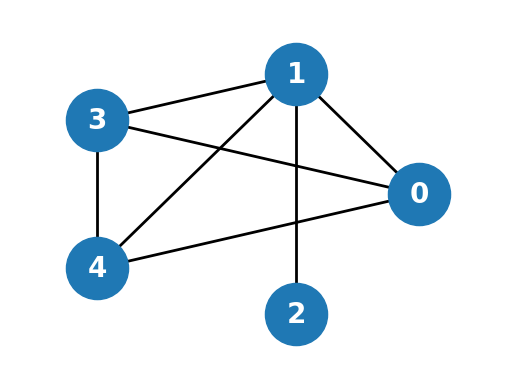

In [34]:
n = 8
p = 10
g, k = random_graph_instance(n)
draw_img(g)

## MetaQAOA算法整体流程

1. 搭建QAOA量子线路，其中ansatz线路包含可以训练的参数
2. 初始化线路中的参数
3. 运行该量子线路，得到量子态$|\psi\rangle$
4. 计算目标哈密顿量$H_C$的期望值$\langle\psi|H_C|\psi\rangle$
5. 根据第4步的结果，使用Adam优化器优化线路中参数，利用元学习（Metalearning）的方法辅助参数优化
6. 重复3-5步，直到第4步结果基本不再变化
7. 根据第4步的结果，算出目标问题的近似解

在该流程中，第2-6步都可以由MindSpore和MindQuantum中现成的包和函数来实现，因此我们将重点关注第1步——量子线路的搭建。

![Flowchart](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_zh_cn/images/QAOA_Flowchart.png)

## 搭建QAOA量子线路

先前提到，我们需要将问题对应的哈密顿量

$$
H_C=\sum_{(i,j)\in C}(Z_iZ_j-1)/2
$$

最小化来找到问题的解，也就是说我们要找到该哈密顿量的基态。对此我们可以采用量子绝热演化的方法，使系统先处于某一简单哈密顿量$H_B$的基态上，然后使简单的哈密顿量$H_B$绝热地、缓慢地演化至某一复杂的哈密顿量$H_C$，根据绝热定理，系统将始终保持在哈密顿量的基态上，最终达到复杂哈密顿量$H_C$的基态。

我们将要搭建的量子线路就是采用以上思路，选取初始简单哈密顿量为

$$
H_B=\sum_i X_i
$$

并将量子线路制备到$H_B$的基态$|s\rangle=|+\rangle^{\otimes n}$，这里通过对所有量子比特作用`Hadamard`门即可实现。然后连接ansatz含参线路，通过不断地优化其中参数可以使得ansatz线路越来越接近真实绝热演化的效果，最终得到的量子线路可以视为模拟近似了一个真实的绝热演化过程。

### ansatz线路

在量子绝热演化中，首先选取初始哈密顿量

$$
H_B=\sum_i X_i
$$

并使系统处于$H_B$的基态$|s\rangle=|+\rangle^{\otimes n}$。然后缓慢地作用如下含时哈密顿量

$$
H(t)=(1-\frac{t}{T})H_B+(\frac{t}{T})H_C
$$

注意到当$t=T$时，$H(T)=H_C$。当选取的$T$足够大时（满足绝热条件），系统将始终处于$H(t)$的瞬时基态上，此时系统的量子态将从初始哈密顿量$H_B$的基态$|\psi (0)\rangle$绝热地演化到目标哈密顿量$H_C$的基态$|\psi (T)\rangle$上，即

$$
|\psi (T)\rangle=\mathcal{T}e^{-i\int^{T}_{0} H(t)dt}|\psi(0)\rangle
$$

也就是说，ansatz线路需要模拟的就是$\mathcal{T}e^{-i\int^{T}_{0} H(t)dt}$这一演化过程。接下来我们将对这个式子进行一些近似和化简，使其变为可以在量子线路中实现的形式。

考虑如下trotter公式

$$
\mathcal{T}e^{-i\int^T_0 H(t)dt}=\lim_{N\rightarrow \infty}\prod^N_{l=1}e^{-iH(t_l)\Delta t},\quad \Delta t=\frac{T}{N},\quad t_l=l\Delta t
$$

略去$O(\Delta t^2)$项，得到

$$
\mathcal{T}e^{-i\int^T_0 H(t)dt}\approx \lim_{N\rightarrow \infty}\prod^N_{l=1}e^{-iH_B(1-t_l/T)\Delta t}e^{-iH_C t_l\Delta t/T}
$$

令$\beta_l=(1-t_l/T)\Delta t$，$\gamma_l=t_l\Delta t/T$，并取$N$为一个有限大的整数，即得到QAOA的ansatz

$$
|\psi(\gamma,\beta)\rangle=\prod^p_{l=1}e^{-i\beta_l H_B}e^{-i\gamma_l H_C}|\psi_{in}\rangle
$$

因此我们需要搭建的ansatz线路由$U_C(\gamma)$和$U_B(\beta)$这两个酉变换交替构成，其中$U_C(\gamma)=e^{-i\gamma \sum_{\langle i,j\rangle}Z_i Z_j}$可以由`ZZ`门实现，$U_B(\beta)=e^{-i\beta \sum_i X_i}$则相当于在每个量子比特上作用一个`RX`旋转门，$\gamma$和$\beta$是可训练的参数。

搭建$U_C(\gamma)$对应的量子线路：

In [35]:
def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += ZZ(para).on(i)        # 对图中的每条边作用ZZ门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc

线路展示：

In [36]:
# pylint: disable=W0104
circuit = build_hc(g, 'gamma')
circuit.summary()
print(circuit)

=========Circuit Summary=========
|Total number of gates  : 8.    |
|Parameter gates        : 7.    |
|with 1 parameters are  : gamma.|
|Number qubit of circuit: 5     |
q0: ──ZZ(gamma)────ZZ(gamma)────ZZ(gamma)──────────────────────────────────────────────────────‖
          │            │            │                                                          ‖
q1: ──ZZ(gamma)────────┼────────────┼────────ZZ(gamma)────ZZ(gamma)────ZZ(gamma)───────────────‖
                       │            │            │            │            │                   ‖
q2: ───────────────────┼────────────┼────────ZZ(gamma)────────┼────────────┼───────────────────‖
                       │            │                         │            │                   ‖
q3: ───────────────ZZ(gamma)────────┼─────────────────────ZZ(gamma)────────┼────────ZZ(gamma)──‖
                                    │                                      │            │      ‖
q4: ────────────────────────────ZZ(gamma)─────────────

搭建$U_B(\beta)$对应的量子线路：

In [37]:
def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb

线路展示：

In [38]:
# pylint: disable=W0104
circuit = build_hb(g, 'beta')
circuit.summary()
print(circuit)

=========Circuit Summary=========
|Total number of gates  : 6.    |
|Parameter gates        : 5.    |
|with 1 parameters are  : beta. |
|Number qubit of circuit: 5     |
q0: ──RX(beta)──‖
                ‖
q1: ──RX(beta)──‖
                ‖
q2: ──RX(beta)──‖
                ‖
q3: ──RX(beta)──‖
                ‖
q4: ──RX(beta)──‖


实现了一层酉变换$U_B(\beta) U_C(\gamma)$的ansatz线路如下所示：

In [39]:
# pylint: disable=W0104
circuit = build_hc(g, 'gamma') + build_hb(g, 'beta')
circuit.summary()
print(circuit)

============Circuit Summary============
|Total number of gates  : 14.         |
|Parameter gates        : 12.         |
|with 2 parameters are  : gamma, beta.|
|Number qubit of circuit: 5           |
q0: ──ZZ(gamma)────ZZ(gamma)────ZZ(gamma)──────────────────────────────────────────────────────‖──RX(beta)──‖
          │            │            │                                                          ‖            ‖
q1: ──ZZ(gamma)────────┼────────────┼────────ZZ(gamma)────ZZ(gamma)────ZZ(gamma)───────────────‖──RX(beta)──‖
                       │            │            │            │            │                   ‖            ‖
q2: ───────────────────┼────────────┼────────ZZ(gamma)────────┼────────────┼───────────────────‖──RX(beta)──‖
                       │            │                         │            │                   ‖            ‖
q3: ───────────────ZZ(gamma)────────┼─────────────────────ZZ(gamma)────────┼────────ZZ(gamma)──‖──RX(beta)──‖
                              

实现了论文中的线路（a）（H门之后再添加）
![](https://authoring-modelarts-cnnorth4.huaweicloud.com/c4f2050c-dca9-4fe0-b300-7d2f41eb0881/files/13/6circuit.png?_xsrf=2%7C4640a74f%7Cdc96d402339e9b757b824ff3af5c804b%7C1660641834)

为了使得最后优化的结果足够准确，我们需要将量子线路重复多次，因此我们通过如下函数搭建多层的训练网络：

In [40]:
def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'g{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'b{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    return circ

构建图对应的哈密顿量$H_C=\sum_{(i,j)\in C}(Z_iZ_j-1)/2$（忽略常数项和系数）：

In [41]:
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

### 生成完整的量子线路和图所对应的哈密顿量

这里我们选择`p = 10`，表示选用4层的QAOA量子线路，`ansatz`是求解该问题的量子线路，`init_state_circ`是将量子态制备到均匀叠加态（$H_B$的基态）上的量子线路。

In [42]:
# pylint: disable=W0104
p = 10
ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
ansatz = build_ansatz(g, p)                  # 生成ansatz线路
circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路
circ.summary()
print(circ)

===========================Circuit Summary===========================
|Total number of gates  : 145.                                      |
|Parameter gates        : 120.                                      |
|with 20 parameters are : g0, b0, g1, b1, g2, b2, g3, b3, g4, b4... |
|Number qubit of circuit: 5                                         |
q0: ──H────ZZ(g0)────ZZ(g0)────ZZ(g0)──────────────────────────────────────────‖──RX(b0)──‖──ZZ(g1)────ZZ(g1)────ZZ(g1)──────────────────────────────────────────‖──RX(b1)──‖──ZZ(g2)────ZZ(g2)────ZZ(g2)──────────────────────────────────────────‖──RX(b2)──‖──ZZ(g3)────ZZ(g3)────ZZ(g3)──────────────────────────────────────────‖──RX(b3)──‖──ZZ(g4)────ZZ(g4)────ZZ(g4)──────────────────────────────────────────‖──RX(b4)──‖──ZZ(g5)────ZZ(g5)────ZZ(g5)──────────────────────────────────────────‖──RX(b5)──‖──ZZ(g6)────ZZ(g6)────ZZ(g6)──────────────────────────────────────────‖──RX(b6)──‖──ZZ(g7)────ZZ(g7)────ZZ(g7)───────────────────────────────────────

### 搭建待训练量子神经网络

由于该问题不需要编码层量子线路，我们这里使用`MQAnsatzOnlyLayer`作为待训练的量子神经网络，并采用`Adam`优化器。

In [43]:
from mindspore import nn
class LSTMQAOA(nn.Cell):
    def __init__(self, para_count, hidden_dim, n_layers, ansatz_op):
        super().__init__()
        self.lstm = nn.LSTM(para_count, hidden_dim, n_layers, bidirectional=False, batch_first=True)
        self.ansatz_op = ansatz_op


    def construct(self, inputs, seq_length):
        outputs, _ = self.lstm(inputs, seq_length=seq_length)
        e = self.ansatz_op(outputs.flatten())
        return e, outputs

In [44]:
import mindspore as ms
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")


sim = Simulator('projectq', circ.n_qubits)                     # 创建模拟器，backend使用‘projectq’，能模拟6个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyOps(grad_ops)                              # 生成待训练的神经网络

model = LSTMQAOA(len(circ.params_name), hidden_dim=len(circ.params_name), n_layers=6, ansatz_op=net)
                                                               # 用LSTM跟新神经网络的参数

In [45]:
seq_len = ms.Tensor([1], ms.int64)
print(seq_len.shape)
init_paras = ms.Tensor(np.random.randn(1, 1, len(circ.params_name))*1.57).astype(ms.float32)
initial_energy, next_paras = model(init_paras, seq_len)
print("Initial energy: %20.16f" % (initial_energy.asnumpy()))

(1,)
Initial energy:  -0.1310281604528427


In [46]:
class CustomWithLossCell(nn.Cell):
    """连接前向网络和损失函数"""

    def __init__(self, backbone, loss_fn):
        """输入有两个，前向网络backbone和损失函数loss_fn"""
        super(CustomWithLossCell, self).__init__(auto_prefix=False)
        self._backbone = backbone
        self._loss_fn = loss_fn

    def construct(self, data, seqlen, target):
        output, para = self._backbone(data, seqlen)         # 前向计算得到网络输出
        return self._loss_fn(output, target), para          # 得到多标签损失值


class CustomTrainOneStepCell(nn.Cell):
    """自定义训练网络"""

    def __init__(self, network, optimizer):
        """入参有两个：训练网络，优化器"""
        super(CustomTrainOneStepCell, self).__init__(auto_prefix=False)
        self.network = network                           # 定义前向网络
        self.network.set_grad()                          # 构建反向网络
        self.optimizer = optimizer                       # 定义优化器
        self.weights = self.optimizer.parameters         # 待更新参数
        self.grad = ops.GradOperation(get_by_list=True)  # 反向传播获取梯度

    def construct(self, *inputs):
        loss, out = self.network(*inputs)                       # 计算当前输入的损失函数值
        grads = self.grad(self.network, self.weights)(*inputs)  # 进行反向传播，计算梯度
        self.optimizer(grads)                                   # 使用优化器更新权重参数
        return loss, out

from mindspore import Tensor, ops
class MetaLoss(nn.LossBase):
    def __init__(self):
        super(MetaLoss, self).__init__()
        self.min = ops.Minimum()

    def construct(self, base, target):
        """
            loss函数
        """        
        x = base-target    
        return self.get_loss(x)
    
loss = MetaLoss()
optimizer = nn.Adam(model.trainable_params(), learning_rate=0.001)
target = ms.Tensor([0])
net_with_loss = CustomWithLossCell(model, loss)
train_net = CustomTrainOneStepCell(net_with_loss, optimizer)
train_net.set_train()
history = []
for i in range(2000):
    lo, next_paras = train_net(init_paras, seq_len, target)
    init_paras = ms.Tensor(next_paras.asnumpy()).astype(ms.float32)
    if (i+1)%50==0:
        loss = lo.asnumpy()
        print(f'iter{i+1:04d}: loss {loss}')
        history.append(loss)


import matplotlib.pyplot as plt
plt.plot([50*(i+1) for i in range(len(history))], history, label='LSTM')
plt.savefig('lossfunc.png')

iter0050: loss -1.408046841621399
iter0100: loss -2.156816005706787
iter0150: loss -2.523148536682129
iter0200: loss -2.1318955421447754
iter0250: loss -2.069627046585083
iter0300: loss -2.0940136909484863
iter0350: loss -2.125330686569214
iter0400: loss -2.3081424236297607
iter0450: loss -2.421308994293213
iter0500: loss -2.451437473297119
iter0550: loss -2.471426248550415
iter0600: loss -2.4856040477752686
iter0650: loss -2.496537208557129
iter0700: loss -2.5061914920806885
iter0750: loss -2.5158817768096924
iter0800: loss -2.5266716480255127
iter0850: loss -2.5395824909210205
iter0900: loss -2.5554325580596924
iter0950: loss -2.573906183242798
iter1000: loss -2.5919666290283203
iter1050: loss -2.6049838066101074
iter1100: loss -2.611917734146118
iter1150: loss -2.6152634620666504
iter1200: loss -2.6170363426208496
iter1250: loss -2.6180930137634277
iter1300: loss -2.6187808513641357
iter1350: loss -2.619260787963867
iter1400: loss -2.6196112632751465
iter1450: loss -2.61987757682800

## 训练并展示结果

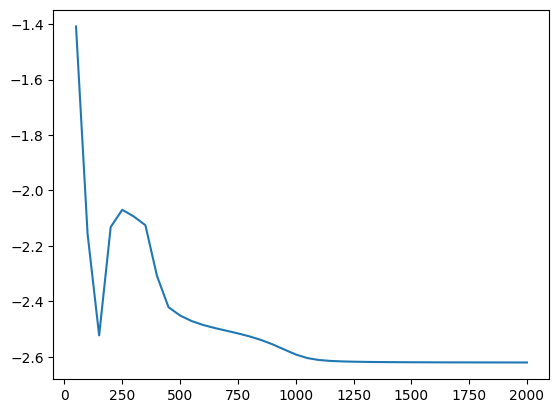

In [47]:
plt.show()

## 总结

这里我们通过元量子近似优化算法，复现了论文中的线路，并解决了Max-Cut问题，并得到了案例中的图对应的最大切割方案。

## 参考文献

[1] Edward Farhi, Jeffrey Goldstone, and Sam Gutmann. [A Quantum Approximate Optimization Algorithm](https://arxiv.org/pdf/1411.4028.pdf)

[2] Haibin Wang , Jiaojiao Zhao, Bosi Wang, and Lian Tong. [A Quantum Approximate Optimization Algorithm with Metalearning for MaxCut Problem and Its Simulation via TensorFlow Quantum](https://www.hindawi.com/journals/mpe/2021/6655455/#data-availability)
